In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
from keras.optimizers import RMSprop,Adam
from keras import regularizers

import tensorflow as tf 

from scipy.misc import imresize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from PIL import Image

from keras.preprocessing.image import array_to_img , img_to_array , load_img ,ImageDataGenerator 

from subprocess import check_output
#print (check_output(["ls", "../myproject"]).decode("utf8"))

Using TensorFlow backend.


In [2]:
data_dir = "train/"
mask_dir = "train_masks/"
all_images = os.listdir(data_dir)

In [3]:
train_images, validation_images = train_test_split(all_images, train_size=0.8, test_size=0.2)
print len(train_images)
#content_image=Image.open('train/fc5f1a3a66cf_06.jpg')
#content_image.size

4070


In [4]:
def grey2rgb_2(img):
    new_img=np.array(list(img)*3)
    new_img=new_img.reshape(img.shape[0],img.shape[1],3)
    return new_img

In [5]:
size=512

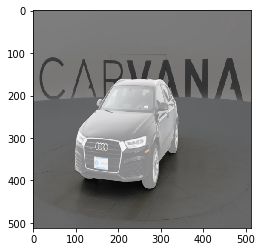

In [6]:
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img


# generator that we will use to read the data from the directory
def data_gen_small(data_dir, mask_dir, images, batch_size, dims):
        """
        data_dir: where the actual images are kept
        mask_dir: where the actual masks are kept
        images: the filenames of the images we want to generate batches from
        batch_size: self explanatory
        dims: the dimensions in which we want to rescale our images
        """
        while True:
            batch = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in batch:
                # images
                original_img = load_img(data_dir + images[i])
                resized_img = imresize(original_img, dims+[3])
                array_img = img_to_array(resized_img)/255
                imgs.append(array_img)
                
                # masks
                original_mask = load_img(mask_dir + images[i].split(".")[0] + '_mask.gif')
                resized_mask = imresize(original_mask, dims+[3])
                array_mask = img_to_array(resized_mask)/255
                labels.append(array_mask[:, :, 0])
            imgs = np.array(imgs)
            labels = np.array(labels)
            #print labels
            yield imgs, labels.reshape(-1, dims[0], dims[1], 1)

# example use
train_gen = data_gen_small(data_dir, mask_dir, train_images, 1, [size, size])
img, msk = next(train_gen)

plt.imshow(img[0])
plt.imshow(grey2rgb(msk[0]), alpha=0.5)

In [7]:
def down(input_layers,filters,pool=True):
    conv1=Conv2D(filters,(2,2),padding="same",activation='elu')(input_layers)
    residual = Conv2D(filters, (3, 3), padding='same', activation='elu')(conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual

def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='elu')(concat)
    conv2 = Conv2D(filters, (3, 3), padding='same', activation='elu')(conv1)
    return conv2

In [8]:
# Make a custom U-nets implementation.
filters = 64
input_layer = Input(shape = [size,size, 3])
layers = [input_layer]
residuals = []

# Down 1, 128
d1, res1 = down(input_layer, filters)
residuals.append(res1)

filters *= 2

# Down 2, 64
d2, res2 = down(d1, filters)
residuals.append(res2)

filters *= 2

# Down 3, 32
d3, res3 = down(d2, filters)
residuals.append(res3)

filters *= 2

# Down 4, 16
d4, res4 = down(d3, filters)
residuals.append(res4)

filters *= 2

# Down 5, 8
d5 = down(d4, filters, pool=False)

# Up 1, 16
up1 = up(d5, residual=residuals[-1], filters=filters/2)

filters /= 2

# Up 2,  32
up2 = up(up1, residual=residuals[-2], filters=filters/2)

filters /= 2

# Up 3, 64
up3 = up(up2, residual=residuals[-3], filters=filters/2)

filters /= 2

# Up 4, 128
up4 = up(up3, residual=residuals[-4], filters=filters/2)

out = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(up4)

model = Model(input_layer, out)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 512, 512, 64)  832         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 512, 512, 64)  36928       conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 256, 256, 64)  0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [10]:
from keras.losses import binary_crossentropy
import keras.backend as K


def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


In [11]:
model.compile(optimizer=Adam(1e-4), loss= bce_dice_loss, metrics=[dice_coeff])
model.fit_generator(train_gen, steps_per_epoch=100,epochs=10)

Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[1,512,512,64]
	 [[Node: conv2d_20/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](up_sampling2d_4/ResizeNearestNeighbor, conv2d_20/kernel/read)]]
	 [[Node: Mean_4/_37 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_3358_Mean_4", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'conv2d_20/convolution', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/saurabh/myproject/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-4f4bbfd7df36>", line 50, in <module>
    up4 = up(up3, residual=residuals[-4], filters=filters/2)
  File "<ipython-input-7-9c0bec78ec90>", line 13, in up
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/keras/engine/topology.py", line 596, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/keras/layers/convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 3156, in conv2d
    data_format='NHWC')
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 670, in convolution
    op=op)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 338, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 662, in op
    name=name)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 131, in _non_atrous_convolution
    name=name)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 399, in conv2d
    data_format=data_format, name=name)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/saurabh/myproject/tensorflow/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1,512,512,64]
	 [[Node: conv2d_20/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](up_sampling2d_4/ResizeNearestNeighbor, conv2d_20/kernel/read)]]
	 [[Node: Mean_4/_37 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_3358_Mean_4", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [11]:
#accuracy = model.evaluate(test_x, test_y, verbose=1)

In [14]:
validation_gen = data_gen_small(data_dir, mask_dir, validation_images, 1, [size, size])
img, msk = next(train_gen)

In [15]:
model.evaluate_generator(validation_gen,100)

[0.074574409052729607, 0.960579719543457]